<a href="https://colab.research.google.com/github/Perales64/ControlTemperaturaPID/blob/main/TemperaturaPID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Temperatura PID

Necesitamos conocer la temperatura que entra y sale del sistema. Usaremos ecuaciones para modelar el sistema térmico.

Temperatura de entrada: Aumenta cuando la corriente eléctrica fluye por el transistor.

Temperatura de salida: La energía se dispersa por convección y radiación.
$$\frac{ΔQ}{Δt}=Q_{in}-Q_{out}$$
Temperatura de entrada:
$$Q_{in}-\alpha Q_i$$

$Q_i$ es el porcentaje de salida del calentador. El parámetro α es un factor que relaciona la salida del calentador $(0-100\%)$ con la potencia disipada por el transistor en vatios.
La temperatura de salida es dada por:
$$Q_{out}=k_T​(T−T_∞)+ϵσA(T^4
 −T^4_∞)$$

El primer término de la ecuación se conoce como la Ley de enfriamiento de newton y el segundo como la Ley de Stefan-Boltzmann

$k_T$ constante de perdida para el ambiente, $T$ temperatura del transistor,
$T_\infty$ temperatura del ambiente, ϵ  emisividad, $σ$ es la constante de Stefan-Boltzmann, $A$ es el área
donde:
$$kT=UA$$
$U$ es el coeficiente de transferencia de calor, $A$ es el área
Reemplazando valores tenemos que:
$$\dfrac{\Delta Q}{\Delta t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$
tilizando el concepto de derivada

$$\dfrac{d Q}{d t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$
Podemos calcular el calor liberado o absorbido utilizando el calor específico, $c_p$, la masa, $m$, del componente y el cambio en temperatura $(T-T_{ref})$ en la ecuación:
$$Q=mc_p(T−T_{ref})$$
reemplazando tenemos:
$$mc_p\dfrac{d T}{d t}-mc_p\dfrac{d T_{ref}}{d t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$
Considerando que la temperatura de referencia es constante, por lo tanto la derivada da CERO, llegamos al modelo matemático de la temperatura del transistor:

$$mc_p\dfrac{d T}{d t}=\alpha Q_i+UA(T_{\infty}-T)+\epsilon \sigma A (T_{\infty}^4-T^4)$$

## Parametros del modelo

In [87]:
!pip install control
!pip install serial

In [73]:
import pandas as pd

# Define los datos
data = {
    'Parámetro': ['Temperatura inicial (T0)', 'Temperatura Ambiente (T∞)', 'Salida del Calentador (Q)', 'Factor del Calentador (α)', 'Capacidad Calorifica (Cp)', 'Area de la superficie (A)', 'Masa (m)', 'Coeficiente de transferencia de calor(U)', 'Emisividad (ε)', 'Stefan Boltzmann Constant (σ)'],
    'Valor': ['296.15 K (23oC)', '296.15 K (23oC)', '1', '0.014', '500 J/kg-K', '1.2e-3', '0.004 kg (4 gm)', '5', '0.9', '5.67e-8'],
    'Unidad': ['K', 'K', 'W', 'W/(% heater)', 'J/kg-K', 'm2', 'kg', 'W/m2-K', '', 'W/m2-K4']
}
# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)  # This line creates the DataFrame
# Solicitar al usuario los valores en Celsius
temp_inicial_c = float(input("Ingresa la temperatura inicial en Celsius: "))
temp_ambiente_c = float(input("Ingresa la temperatura ambiente en Celsius: "))

# Convertir a Kelvin
temp_inicial_k = temp_inicial_c + 273.15
temp_ambiente_k = temp_ambiente_c + 273.15

# Actualizar los valores en el DataFrame
df.loc[df['Parámetro'] == 'Temperatura inicial (T0)', 'Valor'] = temp_inicial_k
df.loc[df['Parámetro'] == 'Temperatura Ambiente (T∞)', 'Valor'] = temp_ambiente_k

# Mostrar el DataFrame actualizado
display(df)

Ingresa la temperatura inicial en Celsius: 45
Ingresa la temperatura ambiente en Celsius: 45


,Parámetro,Valor,Unidad
0,Temperatura inicial (T0),318.15,K
1,Temperatura Ambiente (T∞),318.15,K
2,Salida del Calentador (Q),1,W
3,Factor del Calentador (α),0.014,W/(% heater)
4,Capacidad Calorifica (Cp),500 J/kg-K,J/kg-K
5,Area de la superficie (A),1.2e-3,m2
6,Masa (m),0.004 kg (4 gm),kg
7,Coeficiente de transferencia de calor(U),5,W/m2-K
8,Emisividad (ε),0.9,
9,Stefan Boltzmann Constant (σ),5.67e-8,W/m2-K4


## Linealización del Modelo Térmico
Por causa del término de $T^4$ agregado por la ecuación de radiación de la lay de Stefan Boltzmann, el modelo fenomenológico de la temperatura del transistor es NO lineal.

Procedemos a linealizar el modelo en un punto de equilibrio usando la expansion por series de Taylor.

Comenzamos definiendo el modelo como una función f:
$$f(T,Q_i)=\dfrac{d T}{d t}=\dfrac{\alpha}{mc_p} Q_i+\dfrac{UA}{mc_p}(T_{\infty}-T)+\dfrac{\epsilon \sigma A}{mc_p} (T_{\infty}^4-T^4)$$

## Punto de Equilibrio
En el punto de equilibrio la derivada es nula, debido a que ya no existe más variación de temperatura dado que el sistema se ha estacionado.
$$0=αQ_{is}+UA(T_{∞s}−T_s)+ϵσA(T_{∞s}^4−T_s^4)$$

De esa forma llegamos a una ecuación algebraica de orden 4:
$$(ϵσA)T_s^4+(UA)T_s−(αQ_{is}+UAT_{∞s}+ϵσAT_{∞s}^4)=0$$

Debemos encontrar las raíces de la ecuación anterior (serán 4 raíces) y seleccionar únicamente la raíz positiva. Note que la ecuación anterior depende de la entrada Q_{is} que será la cantidad de potencia que vamos a aplicar al transistor para que genere calor.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
eps = float(df.loc[df['Parámetro'] == 'Emisividad (ε)', 'Valor'].iloc[0])
sigma = float(df.loc[df['Parámetro'] == 'Stefan Boltzmann Constant (σ)', 'Valor'].iloc[0])
A = float(df.loc[df['Parámetro'] == 'Area de la superficie (A)', 'Valor'].iloc[0])
U = float(df.loc[df['Parámetro'] == 'Coeficiente de transferencia de calor(U)', 'Valor'].iloc[0])
Qi = float(df.loc[df['Parámetro'] == 'Salida del Calentador (Q)', 'Valor'].iloc[0])
Ta = float(df.loc[df['Parámetro'] == 'Temperatura Ambiente (T∞)', 'Valor'].iloc[0])
alpha = float(df.loc[df['Parámetro'] == 'Factor del Calentador (α)', 'Valor'].iloc[0])

def T_ss(eps, sigma, A, U, Qi, Ta, alpha):
  """
  Calcula la temperatura de equilibrio de un sistema térmico.

  Args:
    eps: Emisividad.
    sigma: Constante de Stefan-Boltzmann.
    A: Área de la superficie.
    U: Coeficiente de transferencia de calor.
    Qi: Salida del calentador.
    Ta: Temperatura ambiente en Kelvin.
    alpha: Factor del calentador.

  Returns:
    Una tupla que contiene la temperatura de equilibrio en Kelvin y Celsius.
  """
  # Define los coeficientes de la ecuación polinomial
  p = [eps * sigma * A, 0, 0, U * A, -alpha * Qi - U * A * Ta - eps * sigma * A * Ta**4]

  # Encuentra las raíces de la ecuación polinomial
  rp = np.roots(p)

  # Selecciona la raíz real y positiva
  Ts = [r for r in rp if np.isreal(r) and r > 0]

  # Devuelve las temperaturas en Kelvin y Celsius
  TK = Ts[0]  # Toma la primera raíz real y positiva
  TC = TK - 273.15

  return TK, TC
  # Ejemplo de uso

TK, TC = T_ss(eps, sigma, A, U, Qi, Ta, alpha)
display("Temperatura de equilibrio:", Math(f"$${TK:.4f}K = {TC:.4f} °C$$"))

'Temperatura de equilibrio:'

<IPython.core.display.Math object>

## Series de Taylor
Aplicando las series de Taylor:
Realizando las derivadas parciales con relación a la temperatura y a la entrada evaluando todo en los puntos de equilibrio encontrados anteriormente llegamos a la siguiente ecuación:
$$
\dfrac{dT}{dt}=\left(-\dfrac{UA}{mc_p}-\dfrac{4\epsilon \sigma A}{mc_p} T_s^3\right)\Delta T+\left( \dfrac{\alpha}{mc_p}\right)\Delta Q+\left.\begin{matrix}\dfrac{dT}{dt}\end{matrix}\right|_{T_s,Q_{is}}$$
$$\dfrac{d\Delta T}{dt}=\left(-\dfrac{UA}{mc_p}-\dfrac{4\epsilon \sigma A}{mc_p} T_s^3\right)\Delta T+\left( \dfrac{\alpha}{mc_p}\right)\Delta Q$$

## Función de Transferencia
Aplicando la transformada de Laplace al modelo lineal encontrado usando las series de Taylor:
$$
\dfrac{\Delta T(s)}{\Delta Q(s)}=\dfrac{\left( \dfrac{\alpha}{mc_p}\right)}{s+\left(\dfrac{UA}{mc_p}+\dfrac{4\epsilon \sigma A}{mc_p} T_s^3\right)}$$
Reemplazando los valores de la tabla y encontrando un punto de equilibrio cuando no estoy inyectando potencia en el transistor Q_{is}=0.

In [75]:
import pandas as pd
import control
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
# ... (previous code from the provided file) ...

# Assuming 'df' DataFrame is already created and populated as in the provided code.

def calculate_transfer_function(df):
    """Calculates the transfer function parameters."""

    # Extract parameters from the DataFrame.  Error handling added for robustness.
    try:
        alpha = float(df.loc[df['Parámetro'] == 'Factor del Calentador (α)', 'Valor'].iloc[0].split(' ')[0].split('/')[0])
        m = float(df.loc[df['Parámetro'] == 'Masa (m)', 'Valor'].iloc[0].split(' ')[0])
        cp = float(df.loc[df['Parámetro'] == 'Capacidad Calorifica (Cp)', 'Valor'].iloc[0].split(' ')[0])
        U = float(df.loc[df['Parámetro'] == 'Coeficiente de transferencia de calor(U)', 'Valor'].iloc[0].split(' ')[0])
        A = float(df.loc[df['Parámetro'] == 'Area de la superficie (A)', 'Valor'].iloc[0].replace('×10-3', 'e-3').split(' ')[0])
        eps = float(df.loc[df['Parámetro'] == 'Emisividad (ε)', 'Valor'].iloc[0])
        sigma = float(df.loc[df['Parámetro'] == 'Stefan Boltzmann Constant (σ)', 'Valor'].iloc[0].replace('×10-8', 'e-8'))
        Ts, _ = T_ss(eps, sigma, A, U, 0, float(df.loc[df['Parámetro'] == 'Temperatura Ambiente (T∞)', 'Valor'].iloc[0]), alpha) # Equilibrium temperature when Qi=0

    except (ValueError, IndexError, AttributeError) as e:
        print(f"Error extracting parameters from DataFrame: {e}")
        return None, None, None


    # Calculate transfer function components
    num = alpha / (m * cp)
    den_s = 1
    den_const = (U * A / (m * cp)) + (4 * eps * sigma * A * Ts**3 / (m * cp))

    return num, den_s, den_const

# Calcular la función de transferencia
num, den_s, den_const = calculate_transfer_function(df)

if num is not None and den_const is not None:
    # Formatear la función de transferencia
    tf_str = f"G(s) = {num:.4f} / (s + {den_const:.4f})"
    print("\n--- Función de Transferencia ---\n")
    # Mostrar la función de transferencia en LaTeX
    display(Math(f"$$ G(s) = \\frac{{{num:.4f}}}{{s + {den_const}}} $$"))
else:
    print("No se pudo calcular la función de transferencia.")


--- Función de Transferencia ---



<IPython.core.display.Math object>

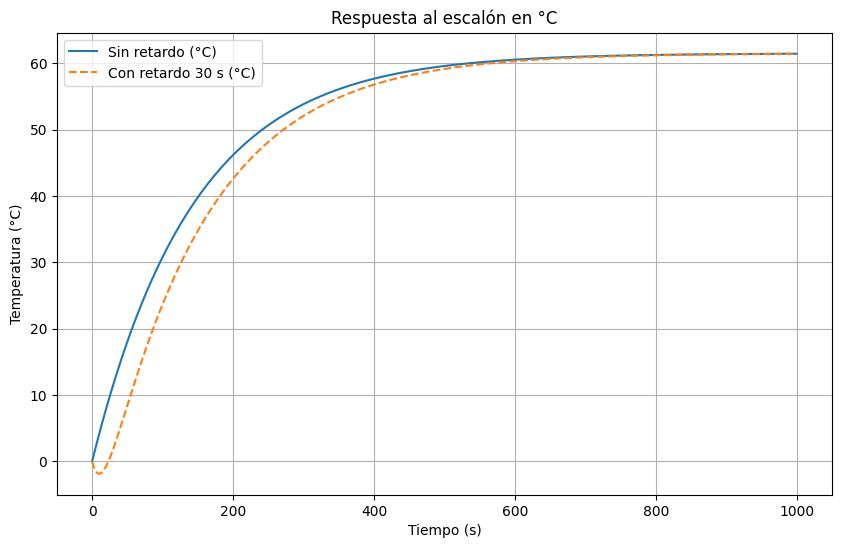

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Definir la función de transferencia original
den = [1, den_const]  # Denominador: s + 0.00618...
sys = ctrl.TransferFunction(num, den)
#Retardo de 10 segundos
delay_time = 30 # Retardo en segundos
pade_num, pade_den = ctrl.pade(delay_time, 1)
delay_tf = ctrl.TransferFunction(pade_num, pade_den)

# Sistema con retardo aproximado
sys_with_delay = sys * delay_tf
# Tiempo de simulación
t = np.linspace(0, 1000, 1000)

# Respuesta al escalón del sistema original y con retardo
t_orig, y_orig = ctrl.step_response(sys, T=t)
t_delay, y_delay = ctrl.step_response(sys_with_delay, T=t)
# Convertir a °C
y_delay_celsius = y_delay * 61
y_celsius = y_orig * 61  # Escalar la salida
# Gráfica comparativa
plt.figure(figsize=(10, 6))
plt.plot(t, y_celsius, label="Sin retardo (°C)")
plt.plot(t_delay, y_delay_celsius, '--', label=f"Con retardo {delay_time} s (°C)")
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Respuesta al escalón en °C')
plt.grid(True)
plt.legend()
plt.show()

Función de transferencia con retardo aproximado (Padé):
<TransferFunction>: sys[151]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  -0.007 s^3 + 0.0168 s^2 - 0.0168 s + 0.00672
-------------------------------------------------
0.006944 s^3 + 0.01667 s^2 + 0.01667 s + 0.006666



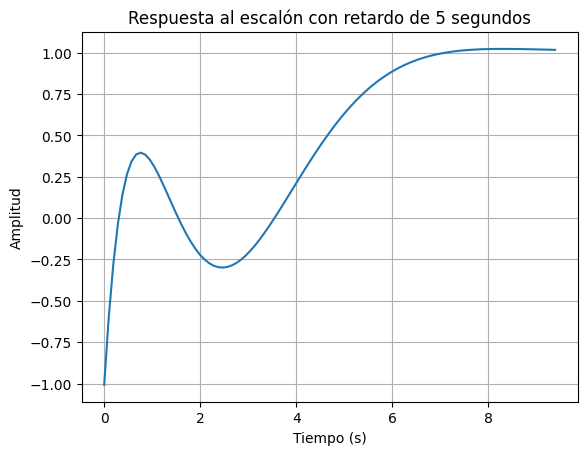

In [78]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

# Crear la función de transferencia sin retardo
G = ctrl.TransferFunction(num, den_const)

# Aproximación de Padé para el retardo de 5 segundos
delay = 5
n = 3  # Orden de la aproximación (puedes ajustarlo)
num_pade, den_pade = ctrl.pade(delay, n)
G_pade = ctrl.TransferFunction(num_pade, den_pade)

# Sistema completo con retardo aproximado
G_with_delay = ctrl.series(G, G_pade)

# Mostrar el resultado
print("Función de transferencia con retardo aproximado (Padé):")
print(G_with_delay)
# Graficar respuesta al escalón
plt.figure()
t, y = ctrl.step_response(G_with_delay)
plt.plot(t, y)
plt.title('Respuesta al escalón con retardo de 5 segundos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

In [89]:
import serial  # Asegúrate de que sea pyserial
from datetime import datetime

# Configura el puerto correcto (verifica con list_ports)
puerto = 'COM3'  # Ejemplo para Windows
baudrate = 9600

try:
    # Intenta abrir el puerto serial
    with serial.Serial(puerto, baudrate, timeout=1) as ser:
        print(f"Conexión exitosa con {puerto}")

        # Guarda los datos en un CSV
        nombre_archivo = f"mediciones_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        with open(nombre_archivo, 'a') as archivo:
            archivo.write("FechaHora,Medicion\n")  # Encabezado

            print("Guardando datos... (Presiona Ctrl+C para detener)")
            try:
                while True:
                    linea = ser.readline().decode('utf-8').strip()
                    if linea:
                        fecha_hora = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                        archivo.write(f"{fecha_hora},{linea}\n")
                        archivo.flush()  # Guarda inmediatamente
                        print(f"Dato: {linea}")
            except KeyboardInterrupt:
                print("\nMedición detenida por el usuario.")

except Exception as e:  # Captura cualquier error genérico
    print(f"Error: {e} (¿El puerto {puerto} existe?)")

Error: module 'serial' has no attribute 'Serial' (¿El puerto COM3 existe?)
